In [1]:
import cv2
import pandas as pd
from imageio import imread
from matplotlib import pyplot as plt

# Low Resolution Fix (Blurry photos)
https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/83185812/L/199904402.jpg?20190323161356  
https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/75772852/L/142442372.jpg?20170420005331

In [2]:
img1 = imread("https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/83185812/L/199904402.jpg?20190323161356")

In [3]:
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
score = cv2.Laplacian(gray, cv2.CV_64F).var()
print (score)

480.85061449584526


In [4]:
img2 = imread("https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/75772852/L/142442372.jpg?20170420005331")

In [5]:
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
score = cv2.Laplacian(gray, cv2.CV_64F).var()
print (score)

262.0868584183023


## Photos with laplacian kernel scores < 481 blurry??
The Laplacian Kernel....
[More on OpenCV Laplace Operator](https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html)

Too low of a threshold and the images will be marked as blurry when they are not. Too high of a threshold then images that are actually blurry will not be marked as blurry.

Based on the 2 photos provided, their laplacian scores ranges 262 to 480. To find out if most non-blurry photos fit into this range, we take the average laplacian scores of our training images.

In [6]:
training_data = pd.read_csv("../data/training_data.csv")

In [7]:
photo_urls = training_data.URL_BIG

# replace empty space with %20
photo_urls = photo_urls.str.replace(" ", "%20")

In [8]:
total_score = 0
tracked_img = []
untracked_img = []

for each_url in photo_urls:
    img = imread(each_url)
    
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        score = cv2.Laplacian(gray, cv2.CV_64F).var()
        tracked_img.append(each_url)
    except:
        untracked_img.append(each_url) # for img that cannot be converted to grayscale
        
    total_score += score
    
print (total_score)

939746.3069394227


In [9]:
# channel 2/3 img cannot be converted to gray
untracked_img

['https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/72590592/L/183673002.jpg?20181030165841',
 'https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/72590592/L/183673012.jpg?20181030165841']

In [10]:
avg_score = total_score/len(tracked_img)
print (avg_score)

1887.0407769867927


Total average scores across our training images seem to be quite high (1887).

588.815172595784


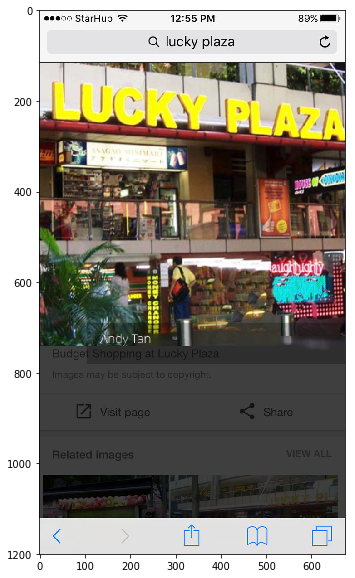

In [11]:
# test blurry img from SRX
test_img = imread("https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/77803682/L/155506532_mobile.jpg?20180727020610")

#plot img
plt.figure(figsize=(10,10))
plt.imshow(test_img)

gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
score = cv2.Laplacian(gray, cv2.CV_64F).var()
print (score)

560.011065398915


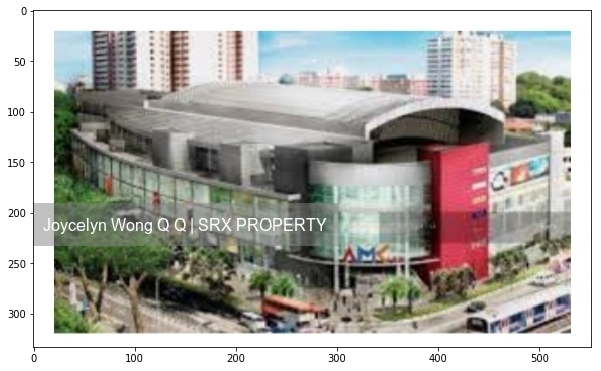

In [12]:
# test blurry img from SRX
test_img = imread("https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/83326112/L/201213352_mobile.jpg?20190414145637")

#plot img
plt.figure(figsize=(10,10))
plt.imshow(test_img)

gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
score = cv2.Laplacian(gray, cv2.CV_64F).var()
print (score)

1333.2499991300883


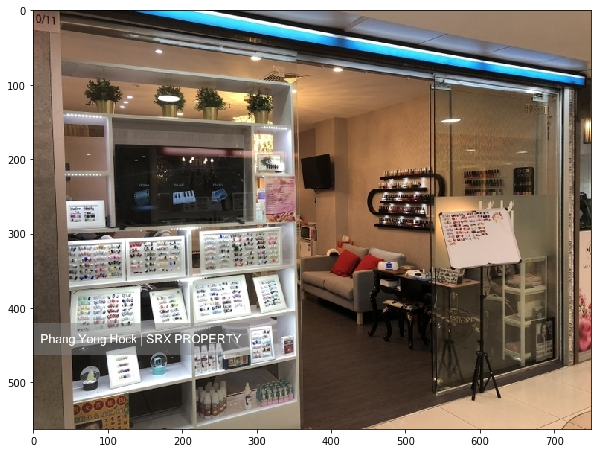

In [13]:
# test non-blurry img from SRX
test_img = imread("https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/78524932/L/166146072_mobile.jpg?20180726181812")

#plot img
plt.figure(figsize=(10,10))
plt.imshow(test_img)

gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
score = cv2.Laplacian(gray, cv2.CV_64F).var()
print (score)

799.8623782067773


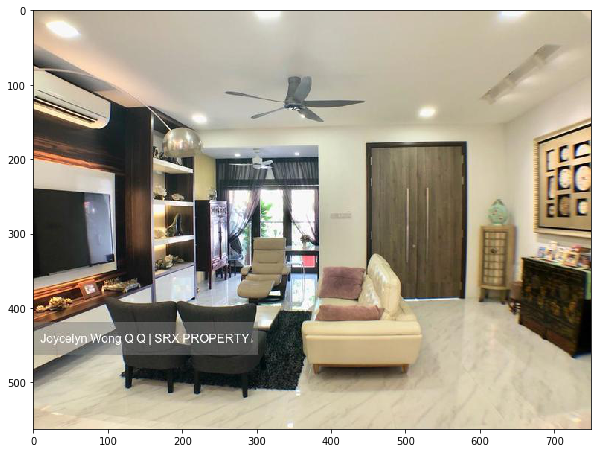

In [14]:
# test non-blurry img from SRX
test_img = imread("https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/83326112/L/201412192_mobile.jpg?20190417151705")

#plot img
plt.figure(figsize=(10,10))
plt.imshow(test_img)

gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
score = cv2.Laplacian(gray, cv2.CV_64F).var()
print (score)

Photos with laplacian score of 799 still looks fine.  
Let's classify training data photos set.

## Classify photos by blurryness

### Setting Laplacian score 600 as threshold

In [15]:
results = []

for each_url in photo_urls:
    img = imread(each_url)
    
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        score = cv2.Laplacian(gray, cv2.CV_64F).var()
        if score < 600:
            r = {"url": each_url, "laplace_score": score, "verdict": "crappy"}
        else:
            r = {"url": each_url, "laplace_score": score, "verdict": "not crappy"}
    except:
        pass # for img that cannot be converted to grayscale
    results.append(r)

In [16]:
results_df = pd.DataFrame(results)
blurry_photos = results_df[results_df['verdict']=="crappy"]
len(blurry_photos)

138

### Eyeball performance of blurry photos

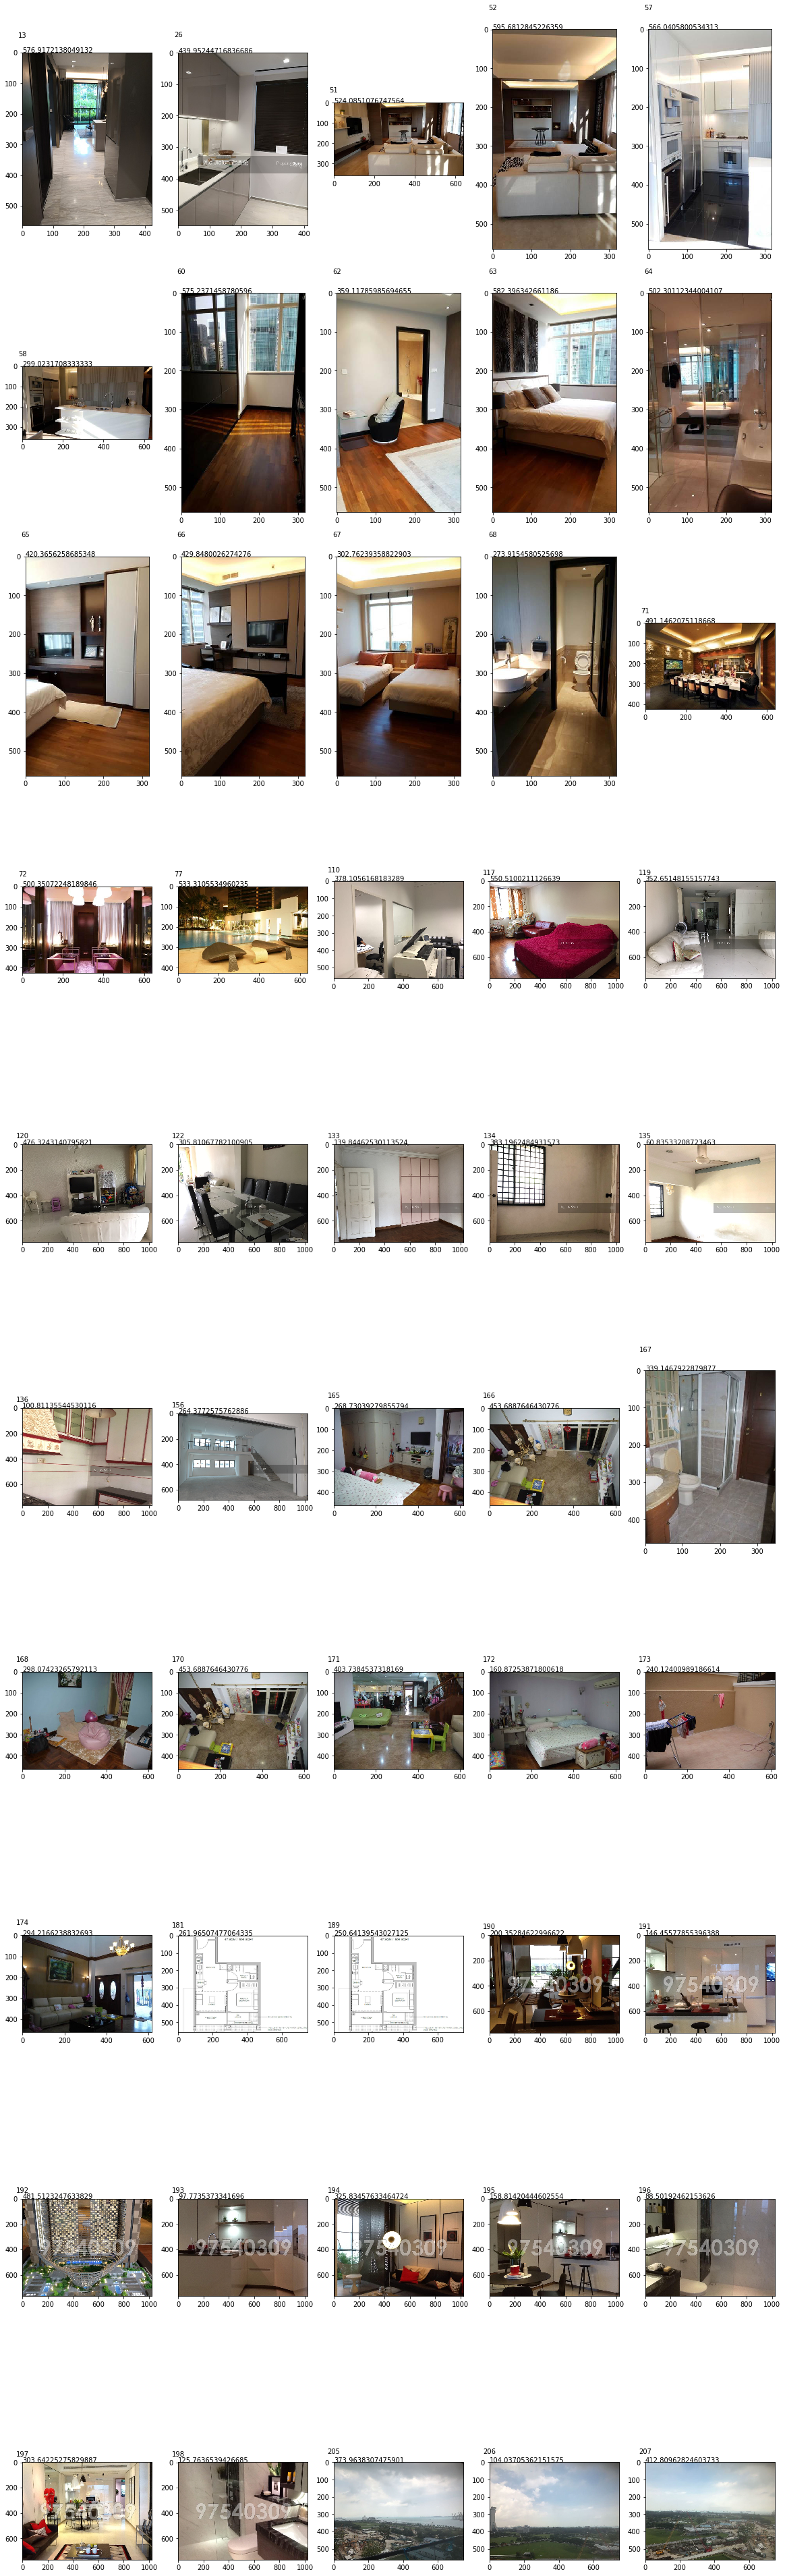

In [17]:
plt.figure(figsize=(20,200))
col = 5
row = int(len(blurry_photos)/col)+1
for n, i in enumerate(blurry_photos.url[0:50]):
    ax = plt.subplot(row,col,n+1)
    img = imread(i)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    score = cv2.Laplacian(gray, cv2.CV_64F).var()
    ax.imshow(img)
    ax.text(0, -50, blurry_photos.index[n], ha='center') #label img index for reference
    ax.text(0, 0, score, ha='left')

### Example: Low score but quality seems fine

In [18]:
blurry_photos.laplace_score[62]

359.11785985694655

In [19]:
blurry_photos.url[62]

'https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/77071872/L/150476132.jpg?20170803161233'

# White Texts Not Detected
https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/83185812/L/200452232.jpg?20190402133658  
https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/83185812/L/200559332.jpg?20190404070941

In [20]:
import pytesseract

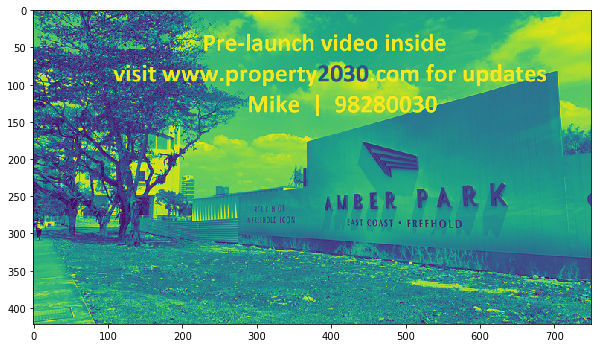

In [21]:
# check for texts
img = imread("https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/83185812/L/200452232.jpg?20190402133658")

#convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#plot gray img
plt.figure(figsize=(10,10))
plt.imshow(gray)

text = pytesseract.image_to_string(img)
print (text)

## Change colorspaces & Set HSV threshold

Using `cv2.cvtColor()` to switch BGR to Gray, then `cv2.inRange()` to extract white colored texts from its background.

[HSV picker](https://wamingo.net/rgbbgr/) to determine `upper white`.

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html

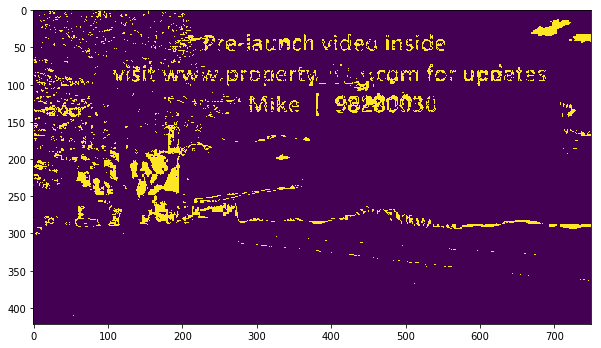

In [166]:
import numpy as np
# check for texts
img = imread("https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/83185812/L/200452232.jpg?20190402133658")

# Convert BGR to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# define range of white color in HSV
lower_white = np.array([0,0,0])
upper_white = np.array([94,18,255]) #determined and tested with HSV Picker

# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_white, upper_white)

#plot mask img
plt.figure(figsize=(10,10))
plt.imshow(mask)

In [167]:
text = pytesseract.image_to_string(mask)
print (text)

Pre-iaunch video inside ale

wisi Daas esis 8 ee iy com for updates
‘Mike 7 Perret

 

ee anes cE a


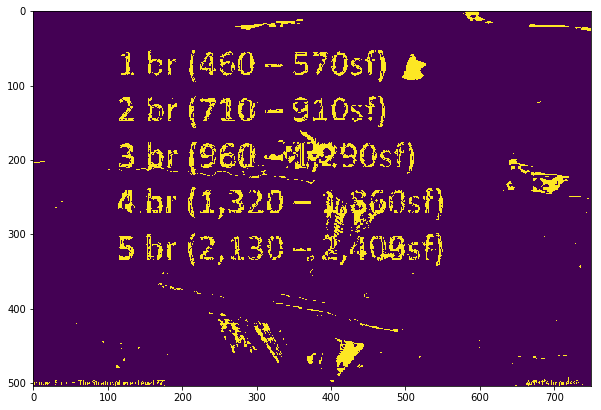

In [164]:
# check for texts
img = imread("https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/83185812/L/200559332.jpg?20190404070941")

# Convert BGR to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# define range of white color in HSV
lower_white = np.array([0,0,0])
upper_white = np.array([101,13,255]) #determined and tested with HSV Picker

# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_white, upper_white)

#plot mask img
plt.figure(figsize=(10,10))
plt.imshow(mask)

In [165]:
text = pytesseract.image_to_string(mask)
print (text)

a

i br (460 ~570sf) ¢
aa E Cer)
aac 60: eon
eee)
(2

mel mice
a rae | * area)

a ae


## Classify photos by white texts

### Define range of white HSV
lower_white = [0,0,0] & upper_white = [101,13,255]

In [168]:
results = []

for each_url in photo_urls:
    img = imread(each_url)
    
    try:
        # Convert BGR to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # define range of white color in HSV
        lower_white = np.array([0,0,0])
        upper_white = np.array([101,13,255]) #determined and tested with HSV Picker

        # Threshold the HSV image to get only blue colors
        mask = cv2.inRange(hsv, lower_white, upper_white)
        
        # detect texts
        text = pytesseract.image_to_string(mask)
        if len(text) > 0:
            r = {"url": each_url, "text": text, "verdict": "crappy"}
        else:
            r = {"url": each_url, "text": text, "verdict": "not crappy"}
    except:
        pass # for img that cannot be converted to grayscale
    
    results.append(r)

### Eyeball performance of photos with white texts detected

In [169]:
results_df = pd.DataFrame(results)
white_texts_photos = results_df[results_df['verdict']=="crappy"]
len(white_texts_photos)

67

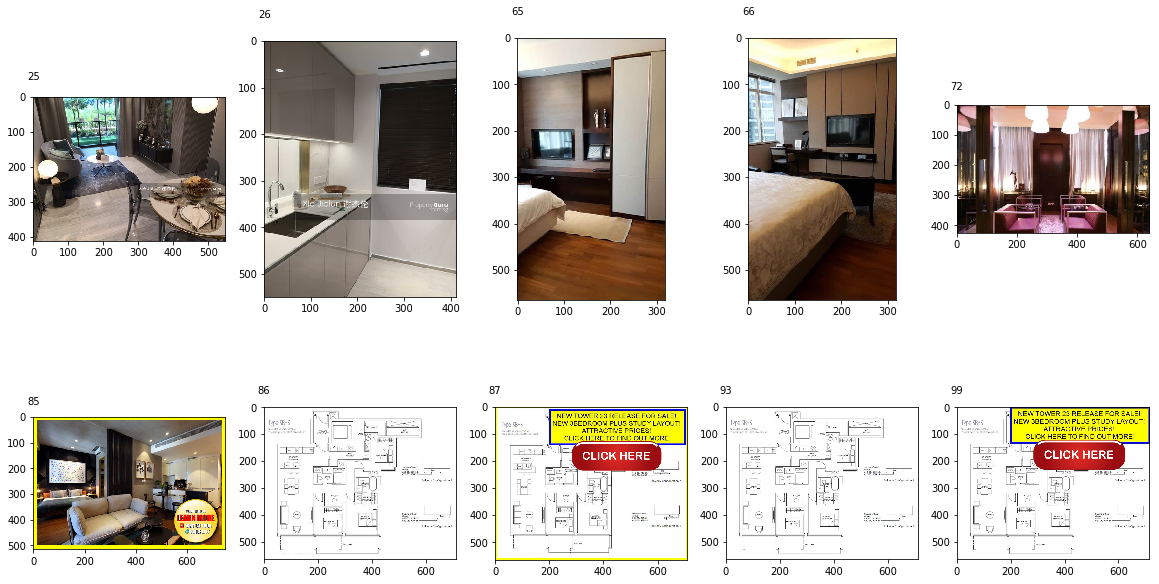

In [180]:
plt.figure(figsize=(20,80))
col = 5
row = int(len(white_texts_photos)/col)+1
for n, i in enumerate(white_texts_photos.url[0:10]):
    ax = plt.subplot(row,col,n+1)
    img = imread(i)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_white = np.array([0,0,0])
    upper_white = np.array([101,13,255]) #determined and tested with HSV Picker

    mask = cv2.inRange(hsv, lower_white, upper_white)

    text = pytesseract.image_to_string(mask, lang='eng')
    ax.imshow(img)
    ax.text(0, -50, white_texts_photos.index[n], ha='center') #label img index for reference

### Example: False positives identified

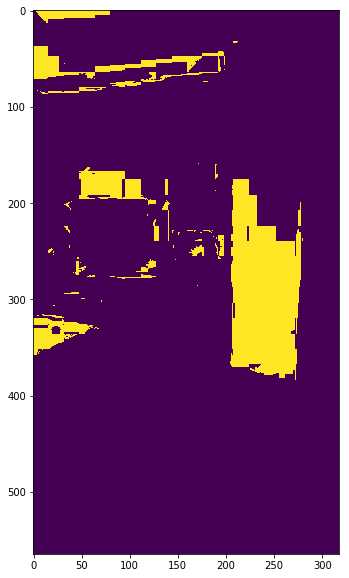

In [64]:
img = imread('https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/77071872/L/150476492.jpg?20170803161411')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_white = np.array([0,0,0])
upper_white = np.array([101,13,255]) #determined and tested with HSV Picker

mask = cv2.inRange(hsv, lower_white, upper_white)

#plot mask img
plt.figure(figsize=(10,10))
plt.imshow(mask)

## Test: New upper white limit

In [183]:
results = []

for each_url in photo_urls:
    img = imread(each_url)
    
    try:
        # Convert BGR to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # define range of white color in HSV
        lower_white = np.array([0,0,0])
        upper_white = np.array([0,0,255]) #determined and tested with HSV Picker

        # Threshold the HSV image to get only blue colors
        mask = cv2.inRange(hsv, lower_white, upper_white)
        
        # detect texts
        text = pytesseract.image_to_string(mask)
        if len(text) > 0:
            r = {"url": each_url, "text": text, "verdict": "crappy"}
        else:
            r = {"url": each_url, "text": text, "verdict": "not crappy"}
    except:
        pass # for img that cannot be converted to grayscale
    
    results.append(r)

In [184]:
results_df = pd.DataFrame(results)
white_texts_photos = results_df[results_df['verdict']=="crappy"]
len(white_texts_photos)

58

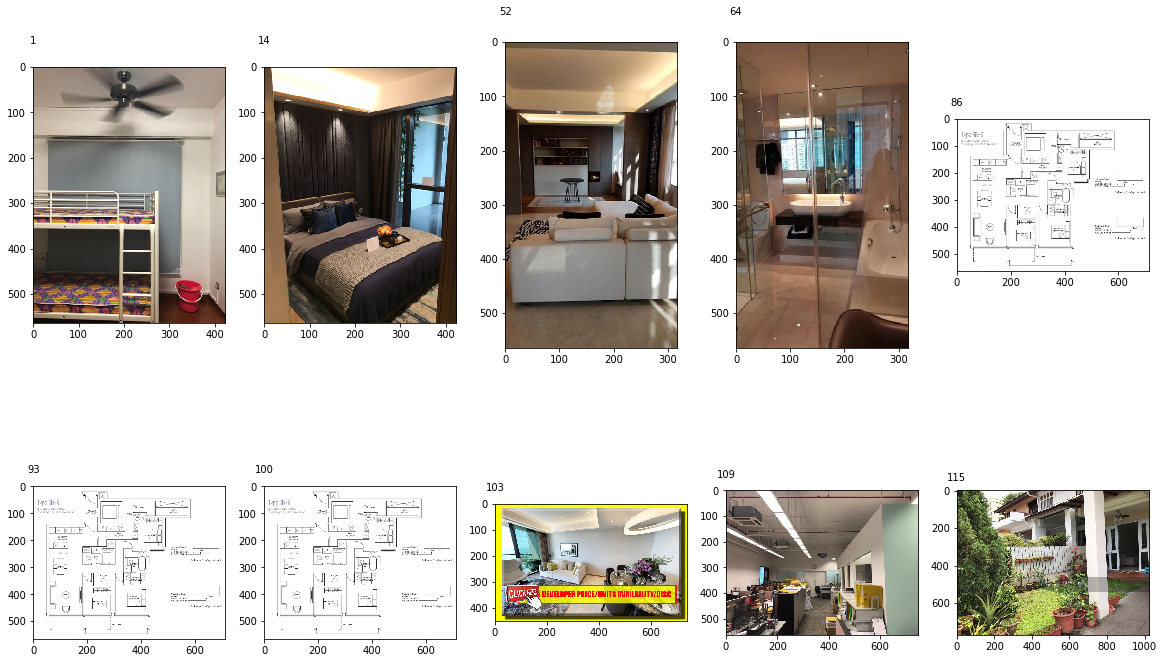

In [185]:
plt.figure(figsize=(20,80))
col = 5
row = int(len(white_texts_photos)/col)+1
for n, i in enumerate(white_texts_photos.url[0:10]):
    ax = plt.subplot(row,col,n+1)
    img = imread(i)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_white = np.array([0,0,0])
    upper_white = np.array([101,13,255]) #determined and tested with HSV Picker

    mask = cv2.inRange(hsv, lower_white, upper_white)

    text = pytesseract.image_to_string(mask, lang='eng')
    ax.imshow(img)
    ax.text(0, -50, white_texts_photos.index[n], ha='center') #label img index for reference

In [186]:
white_texts_photos.text[1]

'a]'

## Try out new method: noise reduction

When presenting with
white text
ona
black background,
you see this


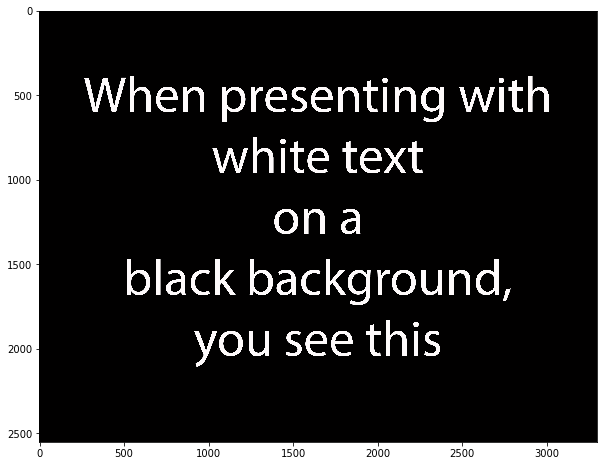

In [122]:
from PIL import Image, ImageOps

img_path = "https://jessicaotis.files.wordpress.com/2017/11/you.jpg"
img = imread(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)

print (pytesseract.image_to_string(img)) ##why is this not detecting

In [132]:
from skimage.restoration import estimate_sigma

def estimate_noise(image_path):
    img = imread(image_path)
    return estimate_sigma(img, multichannel=True, average_sigmas=True)

estimate_noise(img_path)

0.008276293065528035

1.1695669281730096e-30

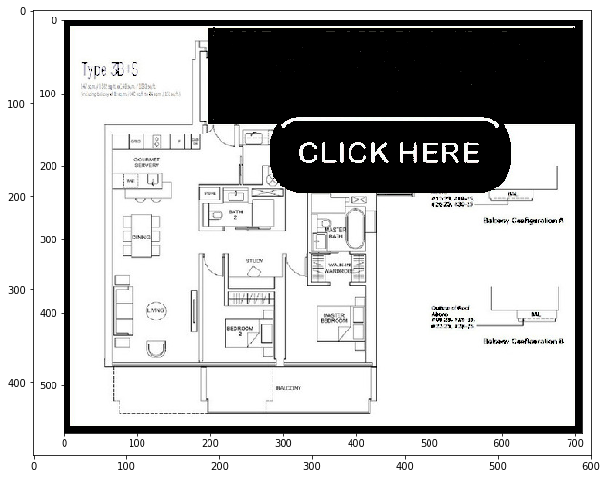

In [133]:
img_path = "download.png"
img = imread(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)

estimate_noise(img_path)

### HD image noise detection
https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.estimate_sigma

0.33976300840753465

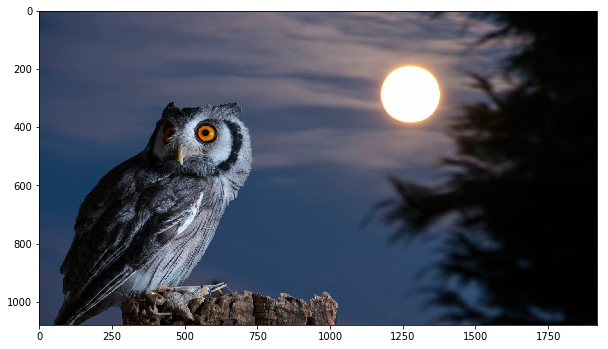

In [134]:
img_path = "http://www.crossfitnorfolk.com/wp-content/uploads/2018/05/Night-Owl-Moon-HD-Wallpaper-desktop-wallpapers-4k-high-definition-windows-10-mac.apple-colourful-images-download-wallpaper-free-1920x1080.jpg"
img = imread(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)

estimate_noise(img_path)    
    

### Non-HD image noise detection

3.986986862611714

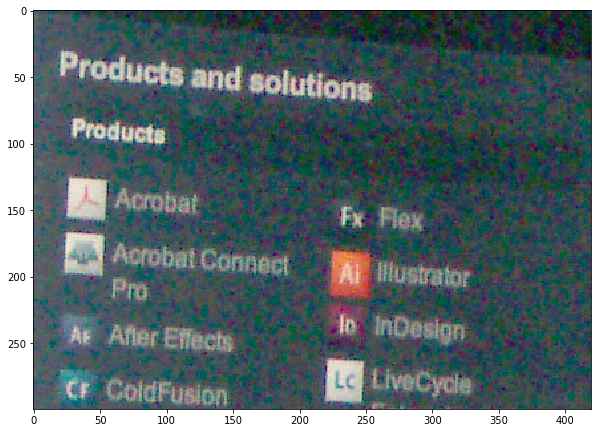

In [135]:
img_path = "https://i.stack.imgur.com/QTrI7.jpg"
img = imread(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)

estimate_noise(img_path)    
#noisy image    

### Denoising image
https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html#sphx-glr-auto-examples-filters-plot-denoise-py

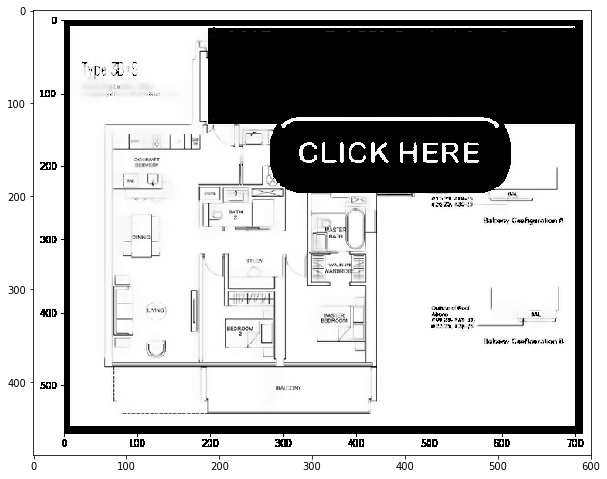

In [156]:
img_path = "download.png"
img = imread(img_path)

dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

plt.figure(figsize=(10,10))
plt.imshow(dst)

# Floorplan/Map Detection

# Face Detected (False Positive)
https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/75772852/L/142442902.jpg?20170420005346

In [ ]:
img_path = "https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/75772852/L/142442902.jpg?20170420005346"
img = imread(img_path)

face_cascade = cv2.CascadeClassifier('./model/trained_model/opencv/haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces = face_cascade.detectMultiScale(imgFile, 1.3, 5)

# Text Detected
https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/75772852/L/142443612.jpg?20170420005402
# Text Not Detected
https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/75772852/L/142443732.jpg?20170420005405
https://s3-ap-southeast-1.amazonaws.com/static.streetsine/Listing%20Photos/Circle/75772852/L/142443802.jpg?20170420005407

# Improve tesseract quality
https://github.com/tesseract-ocr/tesseract/wiki/ImproveQuality